<a href="https://colab.research.google.com/github/ejrtks1020/TensorFlow-PyTorch-Vision/blob/main/pytorch-GAN/pytorch_GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## reference : https://pseudo-lab.github.io/Tutorial-Book/chapters/GAN/Ch3-GAN.html

# 데이터셋 다운로드 (Victorian400, 19세기 그림들의 흑백 / 컬러 쌍으로 이뤄진 데이터)

In [1]:
import os

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [2]:
!kaggle datasets download -d elibooklover/victorian400

 99% 480M/484M [00:03<00:00, 181MB/s]
100% 484M/484M [00:03<00:00, 159MB/s]


In [ ]:
!unzip victorian400.zip

In [4]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

# 데이터셋 클래스 정의

In [5]:
class VictorianDataset(Dataset):
  def __init__(self, root, color_transforms_ = None, gray_transforms_ = None):
    self.color_transforms = transforms.Compose(color_transforms_)
    self.gray_transforms = transforms.Compose(gray_transforms_)
    self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
    self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
  
  def __getitem__(self, index):
    # 흑백이미지는 .convert("L")을 사용하여 단일 채널로 받아온다
    gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
    # 컬러이미지는 .convert("RGB")을 사용하여 3채널로 받아온다
    color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")

    gray_img = self.gray_transforms(gray_img)
    color_img = self.color_transforms(color_img)

    return {"A": gray_img, "B": color_img}
  
  def __len__(self):
    return len(self.gray_files)

In [6]:
!rm -rf test

In [7]:
!mkdir test
!mkdir test/resized; mkdir test/gray

In [8]:
import shutil
test_gray_pngs = sorted(glob.glob("/content/gray/*"))[:10]
test_resized_pngs = sorted(glob.glob("/content/resized/*"))[:10]

for gray_src, resized_src in zip(test_gray_pngs, test_resized_pngs):
  shutil.copyfile(gray_src, '/content/test/gray/' + os.path.basename(gray_src))
  shutil.copyfile(resized_src, '/content/test/resized/' + os.path.basename(resized_src))

In [54]:
root = ''
test_root = root + 'test/'

# 모델 구조에 따라 변경가능
img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 5

gpu = 0

In [10]:
# 데이터셋 클래스의 인자로 넣을 이미지변환(transform)지정

color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]

color_transforms_ = [
                     transforms.Resize(size = (img_height, img_width)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean = color_mean, std = color_std),
]

gray_transforms_ = [
                    transforms.Resize( size = (img_height, img_width)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean = gray_mean, std = gray_std)
]



In [11]:
# 정의한 데이터셋 클래스와 이미지 변환(transform)을 DataLoader함수에 넣어준다.
train_loader = DataLoader(
    VictorianDataset(root, color_transforms_= color_transforms_, gray_transforms_ = gray_transforms_),
    batch_size = batch_size,
    shuffle = True 
)

## 데이터 로더 확인

In [12]:
# 데이터 로더에는 정규화된 이미지가 저장되어 있기때문에 정규화를 복원시키고 시각화해주어야함
def reNormalize(img, mean, std):
  img = img.numpy().transpose(1, 2, 0)
  img = img * std + mean
  img = img.clip(0, 1)
  return img

In [13]:
next(iter(train_loader))['A'][0].shape

torch.Size([1, 256, 256])

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


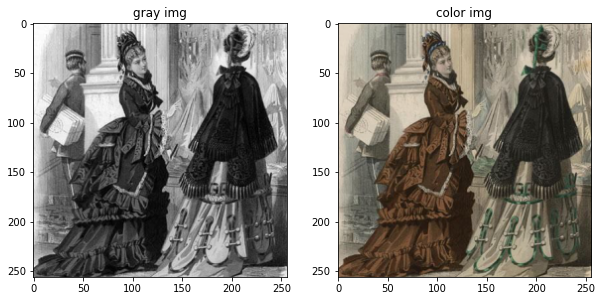

In [14]:
fig = plt.figure(figsize = (10, 5))
rows = 1
cols = 2

for X in train_loader:
  print(X['A'].shape, X['B'].shape)
  ax1 = fig.add_subplot(rows, cols, 1)
  ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap = 'gray')
  ax1.set_title('gray img')

  ax2 = fig.add_subplot(rows, cols, 2)
  ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
  ax2.set_title('color img')

  plt.show()
  break

In [55]:
# 테스트 데이터 로더 정의
test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size = test_batch_size,
    shuffle = False
)

torch.Size([6, 1, 256, 256]) torch.Size([6, 3, 256, 256])


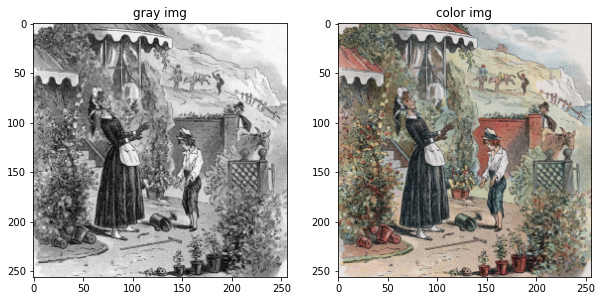

In [16]:
fig = plt.figure(figsize = (10, 5))
rows = 1
cols = 2

for X in test_loader:
  print(X['A'].shape, X['B'].shape)

  ax1 = fig.add_subplot(rows, cols, 1)
  ax1.imshow(reNormalize(X['A'][0], gray_mean, gray_std).reshape(img_height, img_width), cmap = 'gray')
  ax1.set_title('gray img')

  ax2 = fig.add_subplot(rows, cols, 2)
  ax2.imshow(reNormalize(X['B'][0], color_mean, color_std))
  ax2.set_title('color img')

  plt.show()
  break

# 모델 구축

In [17]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    """noise image + gray image"""

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 2,
                  out_channels = 64,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1)      
    )

    self.maxpool = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 64,
                  out_channels = 64 * 2,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.BatchNorm2d(64 * 2),
        nn.LeakyReLU(0.1)      
    )

    self.upsample = nn.Sequential(
        nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )

    self.conv1by1 = nn.Sequential(
        nn.Conv2d(in_channels = 64,
          out_channels = 64,
          kernel_size = 1,
          stride = 1,
          padding = 0),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1)
    )
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 64,
          out_channels = 3,
          kernel_size = 3,
          stride = 1,
          padding = 1),
        nn.Tanh()  
    )
  
  def forward(self, input):
    output1 = self.conv1(input)
    pool1 = self.maxpool(output1)
    output2 = self.conv2(pool1)
    output3 = self.upsample(output2) + output1
    output4 = self.conv1by1(output3)
    out = self.conv(output4)
    return out


In [18]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace = True),

    )

    self.fc = nn.Sequential(
        nn.Linear(1024 * 8 * 8, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, batch_size),
        nn.Sigmoid()
    )

  def forward(self, input, b_size):
    output = self.main(input)
    output = self.fc(output.view(b_size, -1))
    return output
  

In [19]:
# 학습시 배치마다 가중치를 초기화 시켜주어야 함.
# weights_init 함수를 만들어 생성모델(Generator)과 판별모델(Discriminator)에 붙여준다.

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

In [40]:
# 생성모델(Generator)과 판별모델(Discriminator)을 GPU에서 학습시키기위해.cuda(gpu)를 통해 모델을 전달한다.
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [39]:
Disc = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Disc.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

# 모델 학습
* epoch : 50
* optimizer : Adam
* 생성모델 -> 판별모델순으로 학습
* 생성모델에서는 판별모델을 속일 수 있는 컬러 이미지를 생성하도록 학습
* 판별모델에서는 컬러 이미지를 True(real), 흑백이미지를 False(fake)로 인식하도록 학습

In [41]:
max_epoch = 50
optimizerD = torch.optim.Adam(Disc.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [23]:
# 배치 사이즈만큼 노이즈 데이터 생성
noise = torch.randn(12, 1, img_height, img_width)
noise

tensor([[[[ 2.5578e-01, -1.5490e+00, -1.1902e+00,  ..., -1.6878e-01,
            1.1661e+00, -5.5008e-01],
          [ 5.4166e-01,  4.1267e-01,  5.2547e-01,  ..., -1.9172e+00,
            2.3675e-01,  8.4414e-01],
          [ 1.1543e+00, -3.4188e-01,  1.4550e-01,  ...,  1.9641e+00,
            1.3541e+00,  4.1881e-01],
          ...,
          [ 2.9090e-03,  8.2742e-01,  1.0532e+00,  ...,  4.2845e-01,
           -9.4354e-01, -1.1948e+00],
          [-5.4728e-01, -2.9261e-01, -7.1506e-01,  ..., -8.6582e-01,
           -3.0380e-02,  1.2532e+00],
          [-6.8833e-01, -3.7677e-01, -1.0119e+00,  ..., -2.1149e+00,
           -1.1988e+00,  1.5355e-01]]],


        [[[-3.3230e-01,  5.2000e-01,  1.4119e+00,  ..., -6.3863e-01,
            8.9217e-01, -5.4529e-01],
          [-2.9724e-01, -2.6031e-01, -4.5277e-02,  ..., -3.8914e-01,
            7.4581e-01,  1.0083e+00],
          [ 8.8899e-01, -4.0587e-01, -1.1371e+00,  ..., -8.9401e-01,
           -2.0296e+00,  6.0898e-01],
          ...,
   

In [24]:
# 0에서 1사이 값으로 정규화
noise = noise.uniform_(0, 1)
noise

tensor([[[[0.6698, 0.1235, 0.8754,  ..., 0.9715, 0.5222, 0.3937],
          [0.0708, 0.6108, 0.4599,  ..., 0.6655, 0.5732, 0.6083],
          [0.3685, 0.1613, 0.0401,  ..., 0.7463, 0.1409, 0.0646],
          ...,
          [0.9472, 0.1275, 0.8900,  ..., 0.5781, 0.6088, 0.0581],
          [0.1134, 0.1165, 0.3397,  ..., 0.9102, 0.3395, 0.6462],
          [0.3825, 0.2811, 0.7882,  ..., 0.4710, 0.9400, 0.9522]]],


        [[[0.6579, 0.7739, 0.7754,  ..., 0.4563, 0.4105, 0.6156],
          [0.9767, 0.7291, 0.9414,  ..., 0.8080, 0.4346, 0.7720],
          [0.5369, 0.6809, 0.2719,  ..., 0.0275, 0.4652, 0.3116],
          ...,
          [0.5909, 0.8533, 0.2234,  ..., 0.6664, 0.1087, 0.3492],
          [0.5515, 0.5218, 0.0392,  ..., 0.1025, 0.0370, 0.1251],
          [0.2854, 0.1081, 0.5148,  ..., 0.4712, 0.7914, 0.7765]]],


        [[[0.3034, 0.7989, 0.0787,  ..., 0.0269, 0.4216, 0.3075],
          [0.9759, 0.7134, 0.0059,  ..., 0.2374, 0.1612, 0.4655],
          [0.7219, 0.7455, 0.1042,  ..

In [25]:
noise.shape

torch.Size([12, 1, 256, 256])

In [26]:
data = next(iter(train_loader))
grays = data['A']

In [27]:
# gray이미지에 노이즈 채널을 붙여서 2개의 채널로 만든 이미지를 Generator 모델에 입력 -> fake img 생성
gray_noise = Variable(torch.cat([grays, noise], dim = 1).cuda(gpu))
fake_img = Gener(gray_noise)
fake_img.shape

torch.Size([12, 3, 256, 256])

In [28]:
batch = 12

# fake_img를 배치단위로 읽었을때 output ( batch x batch )
output = Disc(fake_img, batch)
output

tensor([[0.4863, 0.4673, 0.5349, 0.4754, 0.4981, 0.5231, 0.4857, 0.5187, 0.4780,
         0.5218, 0.5348, 0.5147],
        [0.4848, 0.4573, 0.5017, 0.4922, 0.4967, 0.5145, 0.4878, 0.5051, 0.5020,
         0.5243, 0.5398, 0.5232],
        [0.4929, 0.4924, 0.5255, 0.5005, 0.4900, 0.4916, 0.4699, 0.5362, 0.4712,
         0.5077, 0.5102, 0.5238],
        [0.4754, 0.4727, 0.5023, 0.4685, 0.4894, 0.4946, 0.4775, 0.5057, 0.4528,
         0.5205, 0.5404, 0.5046],
        [0.4892, 0.4696, 0.5136, 0.4761, 0.4890, 0.5214, 0.4813, 0.5174, 0.4765,
         0.5062, 0.5398, 0.5369],
        [0.4791, 0.4524, 0.4810, 0.4557, 0.4701, 0.5048, 0.4821, 0.5093, 0.4726,
         0.5178, 0.5443, 0.5270],
        [0.4941, 0.4708, 0.4669, 0.4840, 0.4861, 0.5294, 0.4768, 0.5153, 0.5074,
         0.5243, 0.4921, 0.5060],
        [0.5353, 0.4375, 0.4732, 0.5001, 0.4903, 0.5197, 0.4660, 0.5220, 0.4916,
         0.5307, 0.5369, 0.5255],
        [0.4753, 0.4487, 0.5172, 0.4889, 0.4813, 0.5078, 0.4557, 0.5113, 0.4842,

In [29]:
# Generator loss 값
torch.mean((output-1) ** 2)

tensor(0.2517, device='cuda:0', grad_fn=<MeanBackward0>)

In [30]:
color = Variable(data['B'].cuda(gpu))
noises = torch.randn(batch, 1, img_height, img_width).uniform_(0, 1)
gray_noise = Variable(torch.cat([grays, noises], dim = 1).cuda(gpu))

output = Disc(color, batch)
real_loss = torch.mean((output-1) ** 2)

fake_img = Gener(gray_noise)
output = Disc(fake_img, batch)
fake_loss = torch.mean(output ** 2)

In [31]:
real_loss, fake_loss, real_loss + fake_loss

(tensor(0.2513, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2518, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5031, device='cuda:0', grad_fn=<AddBackward0>))

[Epoch 5/50] [Batch 34/34] [D loss: 0.407527] [G loss: 0.739371] ETA: 0:00:32.411209


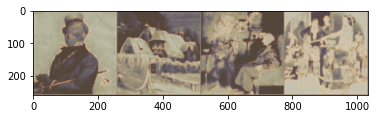

[Epoch 10/50] [Batch 34/34] [D loss: 0.820678] [G loss: 0.965124] ETA: 0:00:32.988208


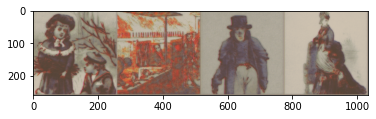

[Epoch 15/50] [Batch 34/34] [D loss: 0.169190] [G loss: 0.764575] ETA: 0:00:33.079471


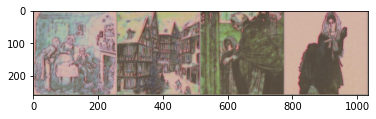

[Epoch 20/50] [Batch 34/34] [D loss: 0.353435] [G loss: 0.716150] ETA: 0:00:33.051871


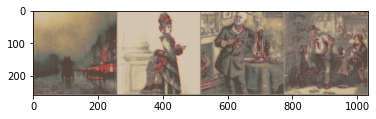

[Epoch 25/50] [Batch 34/34] [D loss: 0.017470] [G loss: 0.984991] ETA: 0:00:33.085805


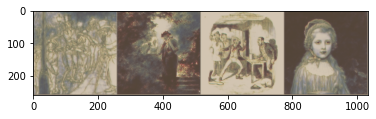

[Epoch 30/50] [Batch 34/34] [D loss: 0.000008] [G loss: 0.999811] ETA: 0:00:33.072601


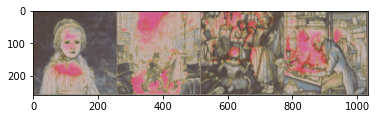

[Epoch 35/50] [Batch 34/34] [D loss: 0.583952] [G loss: 0.999916] ETA: 0:00:33.103247


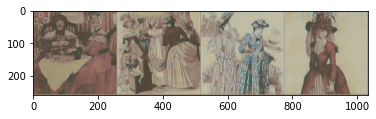

[Epoch 40/50] [Batch 34/34] [D loss: 0.001392] [G loss: 0.994354] ETA: 0:00:33.045313


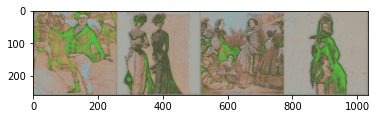

[Epoch 45/50] [Batch 34/34] [D loss: 0.083482] [G loss: 0.987837] ETA: 0:00:33.075982


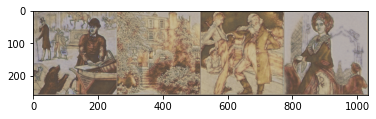

[Epoch 50/50] [Batch 34/34] [D loss: 0.000061] [G loss: 0.999838] ETA: 0:00:33.065567


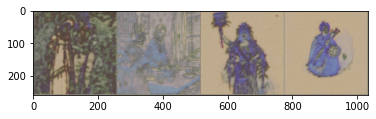

In [42]:
for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        grays, color = data['A'], data['B']
        b_size = len(data['A'])
        

        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        fake_img = Gener(gray_noise)
        output = Disc(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        

        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Disc.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.cuda(gpu))
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)   
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Disc(color,b_size)
        real_loss = torch.mean((output-1)**2)
        

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########        
        fake_img = Gener(gray_noise)   
        output = Disc(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        

        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Disc.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()        


        fake_img = torchvision.utils.make_grid(fake_img.data) 

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), "generator_%d.pth" % (epoch+1))
        torch.save(Disc.state_dict(), "discriminator_%d.pth" % (epoch+1))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
        plt.show()      

# 3.5 예측 및 성능 평가

In [57]:
# 모델의 가중치 불러오기
Gener.load_state_dict(torch.load("generator_45.pth"))
Disc.load_state_dict(torch.load("discriminator_45.pth"))

<All keys matched successfully>

===================input==================


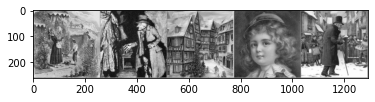

===================target==================


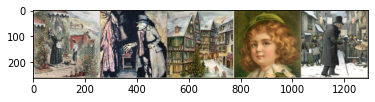

===================output==================


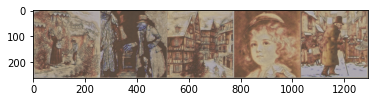

===================input==================


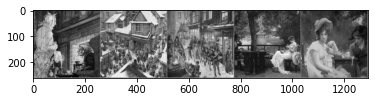

===================target==================


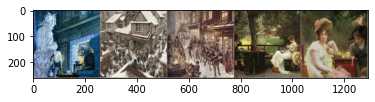

===================output==================


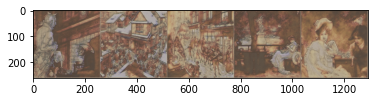

In [58]:
Disc.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0, 1)

for i, data in enumerate(test_loader, 0):
  images, label = data['A'], data['B']

  if len(data['A']) != test_batch_size:
    continue
  
  grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size,  1, img_height, img_width)))
  gray = Variable(torch.cat([grays, fixed_noise], dim = 1).cuda(gpu))

  output = Gener(gray)

  inputs = torchvision.utils.make_grid(grays)
  labels = torchvision.utils.make_grid(label)
  out = torchvision.utils.make_grid(output.data)

  print('===================input==================')
  plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
  plt.show()
  print('===================target==================')
  plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
  plt.show()
  print('===================output==================')
  plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
  plt.show()